# **Gradient Norm during Training**

In [6]:
### IMport libraries
import numpy as np
import tqdm
import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import re
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.autograd import Variable


In [7]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Hyper-parameters
input_size = 784 # 28x28
#n_epo = 100
batch_size = 64


# Load the dataset
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




100%|██████████| 9912422/9912422 [00:00<00:00, 256349031.00it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32607185.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 133865462.64it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13666089.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Define Model**

In [8]:
## Model 1
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Define Training fucntion**

In [9]:
def new_train(model, optimizer, criterion, train_loader, epochs=100):
    losses = []
    gradients = []
    ratios = []
    accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            if batch_idx % 100 == 0:
                # Calculate gradient norm
                total_norm = 0
                for p in model.parameters():
                    param_norm = p.grad.data.norm(2).item()
                    total_norm += param_norm ** 2
                total_norm = total_norm ** (1. / 2)
                gradients.append(total_norm)

        accuracy = 100 * correct / total
        losses.append(running_loss / len(train_loader))
        accuracies.append(accuracy)

        # Calculate minimal ratio
        if gradients[-1] > 0:
            ratio = gradients[-1] / losses[-1]
        else:
            ratio = 0
        ratios.append(ratio)

    return losses, accuracies, gradients, ratios


**Train Model**

In [10]:
# Initialize model, criterion, optimizer
input_size = 784
model = Model1()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train the model
losses, accuracy, gradients, ratios = new_train(model, optimizer, criterion,train_loader)

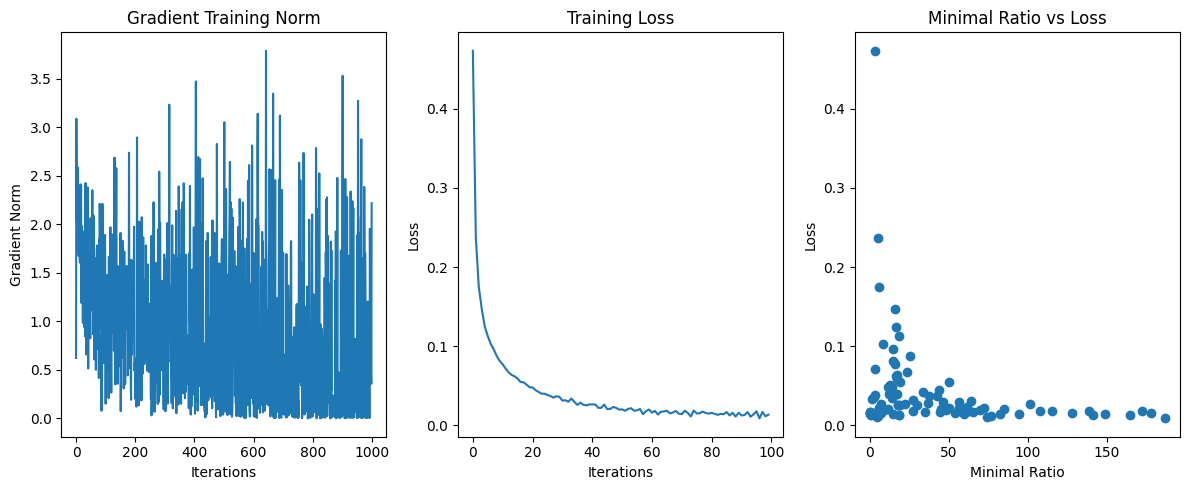

In [13]:
# Plot gradient norm
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(range(len(gradients)), gradients)
plt.title('Gradient Training Norm')
plt.xlabel('Iterations')
plt.ylabel('Gradient Norm')

##Plot training loss
plt.subplot(1, 3, 2)
plt.plot(range(len(losses)), losses)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.tight_layout()

##Plot Minimum ratio to training loss
plt.subplot(1, 3, 3)
plt.scatter(ratios,losses)
plt.ylabel('Loss')
plt.xlabel('Minimal Ratio')
plt.title('Minimal Ratio vs Loss')

plt.show()

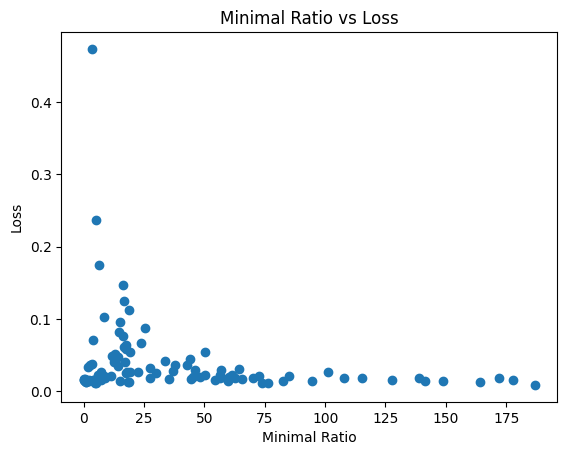

In [12]:
##Plot Minimum ratio to training loss
plt.scatter(ratios,losses)
plt.ylabel('Loss')
plt.xlabel('Minimal Ratio')
plt.title('Minimal Ratio vs Loss')
plt.show()